# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [1]:
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses datasets

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [2]:
import torch
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


## Test data는 validation_matched.csv를 활용하시면 되고, colab으로 불러오는 것은 다음 코드를 참조해주시면 됩니다:

In [4]:
import random
import pandas as pd


def load_data(path, nrows=None):
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data

# 경로 : load_data(path + '/불러올파일명.csv', nrows=1000)
train_ds = load_data(path+'/train.csv', nrows=1000)
test_ds = load_data(path+'/validation_matched.csv', nrows=1000)

DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [5]:
# IMDB 감정 분석 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
# train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
# test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    max_len = 400  # 입력 문장의 최대 길이 설정
    premises, hypotheses, labels = [], [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        # print(f'row: {row}')
        # premise와 hypothesis 분리 처리
        premises.append(row['premise'])
        hypotheses.append(row['hypothesis'])
        labels.append(row['label'])

    # tokenizer로 문장 쌍을 토큰화하고, 최대 길이로 패딩 및 자르기
    # MNLI는 두 문장을 함께 인코딩해야 함
    inputs = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return inputs, labels

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [6]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [7]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')

        # [CLS] 토큰 분류기 정의(3 클래스: entailment, neutral, contradiction)
        self.classifier = nn.Linear(768, 3)

        # 드롭아웃 추가
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(**x)['last_hidden_state']

        x = self.dropout(x)

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])

        return x  # logit 출력

model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [8]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [9]:
def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 로짓(logit) 출력

        # 시그모이드는 생략 가능 (BCEWithLogitsLoss를 썼다면 threshold만 적용)
        preds = torch.argmax(preds, dim=-1)
        # preds = (preds > 0).long()[..., 0]

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환


위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [10]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# 학습 설정
lr = 0.001
model = model.to('cuda')  # 모델을 GPU로 이동
# loss_fn = nn.BCEWithLogitsLoss()  # 이진 분류용 손실 함수
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [11]:
# 학습 루프 함수
def train_model(model, train_loader, test_loader, optimizer, loss_fn, n_epochs=5):
    # 측정값 저장을 위한 리스트 생성
    epoch_losses = []
    train_accuracies = []
    test_accuracies = []

    # 학습 루프
    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()  # 학습 모드 설정

        for inputs, labels in train_loader:
            model.zero_grad()  # 이전 gradient 초기화

            # GPU로 이동
            inputs = {k: v.to('cuda') for k, v in inputs.items()}
            labels = labels.to('cuda')

            # 예측 및 손실 계산
            logits = model(inputs)
            loss = loss_fn(logits, labels)

            # 역전파 및 옵티마이저 단계
            loss.backward()
            optimizer.step()

            total_loss += loss.item()  # loss 누적

        # 각 에폭의 손실값 저장
        epoch_losses.append(total_loss)

        print(f"Epoch {epoch+1:3d} | Train Loss: {total_loss:.4f}")

        # 평가
        with torch.no_grad():
            model.eval()  # 평가 모드로 전환
            train_acc = evaluate(model, train_loader)
            test_acc = evaluate(model, test_loader)

            # 정확도 저장
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            print(f"=========> Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

    return epoch_losses, train_accuracies, test_accuracies

In [12]:
# 정확도 평가 함수
def evaluate(model, dataloader):
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        # GPU로 이동
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
        labels = labels.to('cuda')

        # 예측
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # 정확도 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [13]:
# 모델 학습 실행
n_epochs = 100
losses, train_accs, test_accs = train_model(
    model, train_loader, test_loader, optimizer, loss_fn, n_epochs
)

Epoch   1 | Train Loss: 17.4509
=========> Train acc: 0.4120 | Test acc: 0.3600
Epoch   2 | Train Loss: 17.2631
=========> Train acc: 0.4670 | Test acc: 0.3740
Epoch   3 | Train Loss: 17.0840
=========> Train acc: 0.4600 | Test acc: 0.3720
Epoch   4 | Train Loss: 16.8067
=========> Train acc: 0.4760 | Test acc: 0.3780
Epoch   5 | Train Loss: 16.6946
=========> Train acc: 0.5070 | Test acc: 0.3840
Epoch   6 | Train Loss: 16.5163
=========> Train acc: 0.5110 | Test acc: 0.3890
Epoch   7 | Train Loss: 16.3485
=========> Train acc: 0.5080 | Test acc: 0.3860
Epoch   8 | Train Loss: 16.2579
=========> Train acc: 0.5270 | Test acc: 0.3980
Epoch   9 | Train Loss: 16.0873
=========> Train acc: 0.5360 | Test acc: 0.3990
Epoch  10 | Train Loss: 16.0513
=========> Train acc: 0.5310 | Test acc: 0.4000
Epoch  11 | Train Loss: 15.8696
=========> Train acc: 0.5480 | Test acc: 0.4130
Epoch  12 | Train Loss: 15.7800
=========> Train acc: 0.5470 | Test acc: 0.4050
Epoch  13 | Train Loss: 15.7702
========

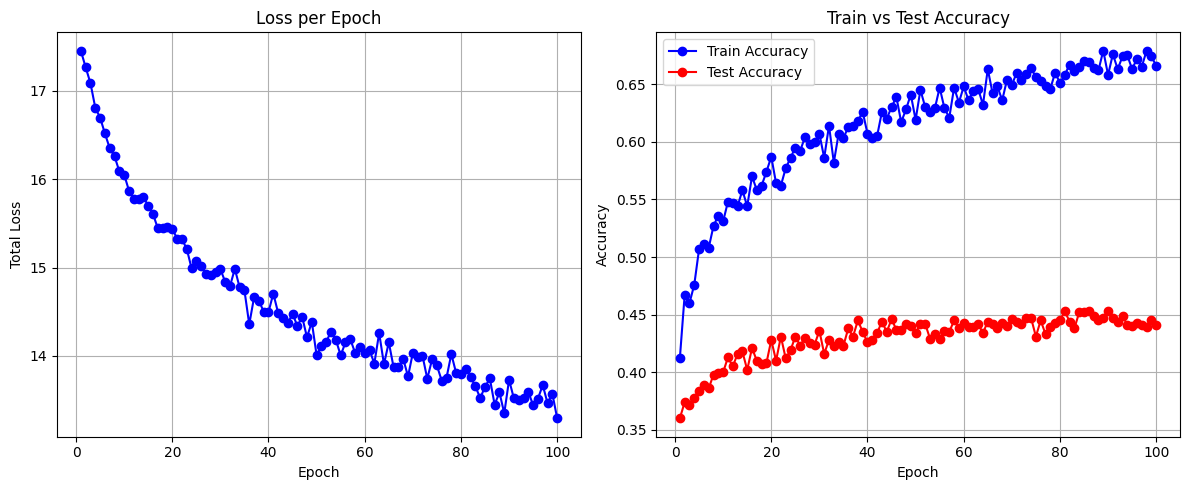

In [14]:
# 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), losses, 'o-', color='blue')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), train_accs, 'o-', color='blue', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), test_accs, 'o-', color='red', label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mnli_training_results.png')
plt.show()

## 결과 분석
1. 과적합 문제 있음
  - 최종 학습 정확도: 67% vs 최종 테스트 정확도: 44%
  - 정화도 차이 o

## 개선 방안
1. 학습률 조정
  - 학습률 스케줄링(learning rate scheduling)
  - 학습률 감소(learning rate decay)

2. 모델 복잡성
  - 현재 모델 보다 모델 구조 복잡하게

3. 데이터 품질
  - 학습 데이터와 테스트 데이터 간의 분포 차이 (확인 필요)
    - 데이터 전처리나 증강